In [103]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize

## Get Training Data

In [2]:
from tensorflow.keras.datasets import fashion_mnist
(X1, y1), (X2, y2) = fashion_mnist.load_data()

X, y = np.vstack((X1, X2)), np.hstack((y1, y2))
np.save('Xf.npy', X)
np.save('yf.npy', y)

## Define LMCs and Cortex objects

In [104]:
def crop_image(img,tol=0):
    # img is 2D image data
    # tol is tolerance
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

class LMC(): # Learnable Memory Column
    def __init__(self, label, penalty_rate, reduction_rate):
        self.support = 0
        self.label = label
        self.rf = None

        self.errors = 0
        self.penalty = None
        self.penalty_rate = penalty_rate

        self.reduction_rate = reduction_rate

    def learn_sample(self, sample):
        self.support += 1
        if self.support == 1:
            self.samples = sample
            self.rf = sample
            self.penalty = np.ones_like(self.rf)
        else:
            self.rf = np.average((self.rf, sample), weights=(self.support, 1), axis=0)
            diff = np.abs(self.rf - sample)
            self.penalty = self.penalty - (diff * self.reduction_rate)

    def learn_error(self, sample):
        self.errors += 1
        diff = np.abs(sample - self.rf)
        self.penalty = self.penalty + (diff * self.penalty_rate)

    def loss(self, sample):
        return np.mean(np.abs(self.rf - sample) * self.penalty)



class Cortex():
    def __init__(self, max_cols_per_label, penalty_rate, reduction_rate):
        self.columns = []
        self.cols_per_label = {}
        self.max_cols_per_label = max_cols_per_label
        self.penalty_rate = penalty_rate
        self.reduction_rate = reduction_rate
    
    # Returns a reference to the strongest LMC
    def predict_label(self, sample):
        # compare the sample to all columns in the cortex
        scores = self.get_scores(sample)
        
        # fetch that recognizes the sample best
        if len(scores) != 0:
            pred = min(scores, key=lambda t: t[1])[0]
            return pred
        else:
            return None

    def get_scores(self, sample):
        # compare the sample to all columns in the cortex
        scores = []
        for c in self.columns:
            s = c.loss(sample)
            scores.append((c, s))
        
        return scores

    def vote_label_prediction(self):
        pass

    def learn_sample(self, label, sample):
        # If this is an unseen label, create a new LMC for it and continue
        if not (label in self.cols_per_label):
            c = LMC(label, self.penalty_rate, self.reduction_rate)
            c.learn_sample(sample)
            self.columns.append(c)
            self.cols_per_label[label] = 1
            return

        # get loss scores for each LMC
        scores = self.get_scores(sample)

        pred = min(scores, key=lambda t: t[1])[0]
        if pred.label == label: # First guess is correct
            pred.learn_sample(sample)
            return
        else: # First guess is wrong
            if self.cols_per_label[label] == self.max_cols_per_label:
                self.force_sample_to_best_column(sample, label)
            else:
                self.cols_per_label[label] += 1
                c = LMC(label, self.penalty_rate, self.reduction_rate)
                c.learn_sample(sample)
                self.columns.append(c)
                self.cols_per_label[label] += 1

        while len(scores) > 0:
            best_tuple = min(scores, key=lambda t: t[1])
            best = best_tuple[0]

            if best.label == label:
                return

            best.learn_error(sample)
            scores.remove(best_tuple)

    def force_sample_to_best_column(self, sample, label):
        scores = []
        for c in self.columns:
            if c.label != label: continue
            scores.append( (c, c.distance_score(sample)) )
        
        best = min(scores, key=lambda t: t[1])[0]
        best.learn_sample(sample)




## Preprocess dataset

In [ ]:
X, y = np.load('X.npy'), np.load('y.npy')

X_ = []
count = 0
for x in X:
    count += 1
    print(count)
    x = crop_image(x)
    x = resize(x, (10, 10))
    X_.append(x)
X = np.array(X_)

np.save('Xp10.npy', X)
print(X.shape)

## Train Model

In [107]:
train_samples = 1000
epochs = 1

X, y = np.load('Xp.npy'), np.load('y.npy')

X = X.reshape((60000, 400))

rate = 2.0

cortex = Cortex(max_cols_per_label=4, penalty_rate=0.001, reduction_rate=0.001)

print('Training...')
for e in range(epochs):
    for i in range(train_samples):
        sample, label = X[i], y[i]
        cortex.learn_sample(label, sample)

print('Testing...')
correct = 0
total = 0
support_list = []
for i in range(50000, 51000):
    pred = cortex.predict_label(X[i])
    
    if pred.label == y[i]:
        correct += 1
    else:
        support_list.append(pred.support)
        # print('Truth: {}, Pred: {}'.format(y[i], pred.label))

        # plt.imshow(np.reshape(y[i], (20,20)))
        # plt.show()

        # plt.imshow(np.reshape(pred.rf, (20,20)))
        # plt.show()

        # print()
        pass

    total += 1

print()
print('{} / {} -> {}'.format(correct, total, (correct / total)))

print('Total Columns in Cortex:', len(cortex.columns))

Training...
Testing...

824 / 1000 -> 0.824
Total Columns in Cortex: 186


In [102]:
print('Testing...')
correct = 0
total = 0
support_list = []
for i in range(40000, 41000):
    pred = cortex.predict_label(X[i])
    
    if pred.label == y[i]:
        correct += 1
    else:
        support_list.append(pred.support)
        print('Truth: {}, Pred: {}'.format(y[i], pred.label))

        # plt.imshow(np.reshape(X[i], (20,20)))
        # plt.show()

        # plt.imshow(np.reshape(pred.rf, (20,20)))
        # plt.show()

        print()
        pass

    total += 1

print()
print('{} / {} -> {}'.format(correct, total, (correct / total)))

print('Total Columns in Cortex:', len(cortex.columns))

Testing...
Truth: 8, Pred: 4

Truth: 8, Pred: 4

Truth: 5, Pred: 3

Truth: 3, Pred: 8

Truth: 5, Pred: 3

Truth: 8, Pred: 7

Truth: 5, Pred: 3

Truth: 9, Pred: 4

Truth: 8, Pred: 3

Truth: 9, Pred: 4

Truth: 3, Pred: 2

Truth: 0, Pred: 6

Truth: 3, Pred: 2

Truth: 2, Pred: 1

Truth: 3, Pred: 8

Truth: 4, Pred: 9

Truth: 3, Pred: 8

Truth: 5, Pred: 3

Truth: 8, Pred: 3

Truth: 0, Pred: 7

Truth: 9, Pred: 3

Truth: 5, Pred: 3

Truth: 9, Pred: 4

Truth: 8, Pred: 7

Truth: 8, Pred: 3

Truth: 0, Pred: 6

Truth: 6, Pred: 3

Truth: 4, Pred: 9

Truth: 5, Pred: 3

Truth: 8, Pred: 7

Truth: 8, Pred: 3

Truth: 7, Pred: 2

Truth: 8, Pred: 7

Truth: 8, Pred: 7

Truth: 6, Pred: 1

Truth: 2, Pred: 9

Truth: 7, Pred: 9

Truth: 4, Pred: 9

Truth: 9, Pred: 4

Truth: 9, Pred: 1

Truth: 8, Pred: 5

Truth: 9, Pred: 7

Truth: 5, Pred: 3

Truth: 5, Pred: 8

Truth: 9, Pred: 4

Truth: 3, Pred: 5

Truth: 3, Pred: 5

Truth: 0, Pred: 6

Truth: 4, Pred: 9

Truth: 2, Pred: 9

Truth: 2, Pred: 1

Truth: 4, Pred: 9

T

## Evaluate Model

Label:  5
Support:  32
Errors:  18


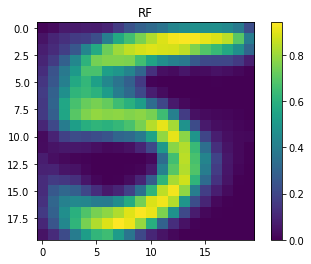

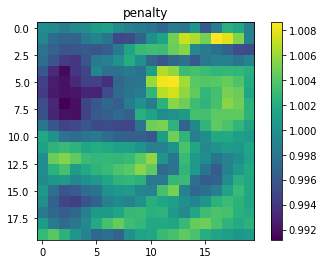


Label:  5
Support:  50
Errors:  27


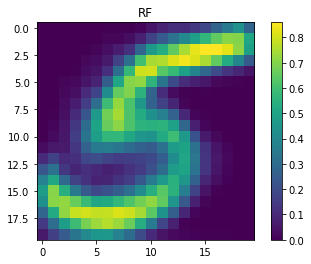

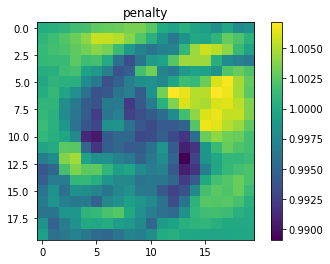


Label:  5
Support:  14
Errors:  5


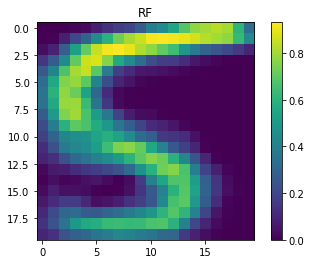

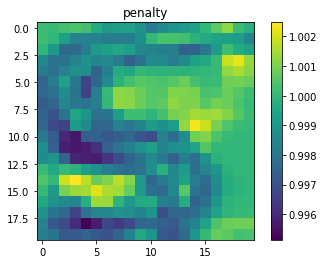


[[  5  32]
 [  0 157]
 [  4  40]
 [  1 162]
 [  9  44]
 [  2  19]
 [  1  52]
 [  3  63]
 [  5  50]
 [  6 137]
 [  7  79]
 [  2  50]
 [  8  73]
 [  9  40]
 [  1   1]
 [  2  16]
 [  4  20]
 [  2  12]
 [  3  56]
 [  7  33]
 [  1  86]
 [  7  87]
 [  8  28]
 [  9   4]
 [  4   6]
 [  4   8]
 [  4  68]
 [  0  48]
 [  1  43]
 [  2  42]
 [  1 147]
 [  9   1]
 [  3  27]
 [  0 150]
 [  4  95]
 [  5  14]
 [  7  12]
 [  2   8]
 [  9  33]
 [  2  17]]


In [96]:
show = 40
shown = 0

support_data = []
for c in cortex.columns:
    support_data.append([c.label, c.support])

    if c.label == 5 or False:
        print('Label: ', c.label)
        print('Support: ', c.support)
        print('Errors: ', c.errors)

        rf = np.reshape(c.rf, (20, 20))
        plt.imshow(rf)
        plt.title('RF')
        plt.colorbar()
        plt.show()

        penalty = np.reshape(c.penalty, (20,20))
        plt.imshow(penalty)
        plt.title('penalty')
        plt.colorbar()
        plt.show()

        print()

    shown += 1
    if shown == show: break

support_data = np.array(support_data)
# print(support_data.shape[0])
# print(np.sum(support_data[:,1] == 1))

print(support_data)

In [46]:
for i in cortex.cols_per_label:
    print(i, cortex.cols_per_label[i])

5 2
0 1
4 2
1 3
9 2
2 4
3 2
6 1
7 2
8 1
